In [1]:
import tensorflow as tf
import chess
import chess.engine
import random
#import cupy as np
import numpy
import tensorflow as tf


# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
stockFish13path = 'A:\\chess\\Chess-AI-with-TensorFlow\\stockfish\\13\\bin\\stockfish_20011801_x64.exe'
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci(stockFish13path) as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

maes = []
model_sizes = []

A:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6



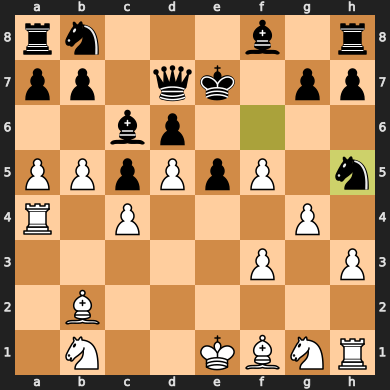

In [3]:
board = random_board()
board

In [4]:
print(stockfish(board, 15))

-538


The Idea is that the Deep Learning Network will predict this score based on the positions of the pieces on the board.

# Creating the dataset

Now we need to convert the board representation to something meaningful.
A 3d matrix of sizes **8 x 8 x 14** where 8x8 repersents the board and the 14 represents the 7 different pieces 

In [5]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [6]:
t = split_dims(board)
t

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        

Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

In [7]:
#import tensorflow.keras
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [8]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(200, 'relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

In [9]:
model = build_model(32, 4)

# It's training time!

In [10]:
import tensorflow.keras.callbacks as callbacks
from sklearn.model_selection import train_test_split

def get_dataset():
	container = numpy.load('dataset.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1) #should we be normalizing. 
	return b, v


boardstates, evaluation  = get_dataset()
x_train, x_test, y_train, y_test = train_test_split(boardstates, evaluation, test_size = 0.2, random_state = random.randint(1, 9999))
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(1200000, 14, 8, 8)
(1200000,)


In [11]:
y_train

array([0.41099057, 0.5821278 , 0.5436508 , ..., 0.4865883 , 0.570876  ,
       0.4213884 ], dtype=float32)

In [12]:
x = numpy.empty(10)
y = numpy.empty(10)
numpy.savez('test.npz', x, y)
container = numpy.load('test.npz')
container.files
a = container['arr_0']
a.size

10

In [13]:
def createData(NumberOfTrainings):
    outfile = 'chessdata1.npz'
    xdata = numpy.empty([NumberOfTrainings, 14,8,8])
    ylables = numpy.empty(NumberOfTrainings)
    for i in range(NumberOfTrainings):
        if(i%10000 == 0):
            numpy.savez(outfile, xdata, ylables)
            print(i)
        board = random_board()
        y = (stockfish(board, 15))  
        x = split_dims(board)
        ylables[i] = y
        xdata[i] = x
    numpy.savez(outfile, xdata, ylables)
    return xdata, ylables
#x_temp, y_temp = createData(250000)
#print(x_temp.shape)
#print(y_temp.shape)
#container = numpy.load('chessdata1.npz')
#x_test2 = container['arr_0']
#y_test2 = container['arr_1']

In [14]:
#print(x_test2.shape)
#print(y_test2.shape)
#print(y_test2[800]) #the ytest2 will be 0 if there is no data in it 

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
def noOptModelComp(model, fit):
    model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])
    model.summary()
    checkpoint_filepath = '\\tmp\\checkpoint\\'
    model_checkpointing_callback = ModelCheckpoint(
        filepath = checkpoint_filepath,
        save_best_only= True,
    )
    if fit:
        fitModel(model)

def fitModel(model):
    #a = callbacks.ReduceLROnPlateau(monitor='loss', patience=10)
    #b = callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)
    history = clustered_model.fit(x_train, y_train,
              batch_size=2048,
              epochs=1000,
              verbose=1,
              validation_split=0.1,
              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10) , tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])
    return history

In [16]:
origModelFile = 'model.h5'
model = tf.keras.models.load_model(origModelFile)
noOptModelComp(model, False) #change to true to re train 
loss, mae, mse = model.evaluate(x_test, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.5f} ".format(mae))
maes.append(mae)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

# Playing with the AI

In [17]:
# used for the minimax algorithm
def minimax_eval(board,model,Tflite):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  if not Tflite:
      return model(board3d)[0][0]
  else:
      board2 = board3d.reshape((1,14,8,8))
      board2 = numpy.float32(board2)
      interpreter.set_tensor(input_index, board2)
      interpreter.invoke()
      prediction = interpreter.get_tensor(output_index)
      fpred = prediction[0][0]
      return fpred

def minimax(board, depth, alpha, beta, maximizing_player,model,Tflite):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board,model, Tflite)
  
  if maximizing_player:
    max_eval = -numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False, model, Tflite)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = numpy.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True, model, Tflite)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth, Tflite):
  max_move = None
  max_eval = -numpy.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False,model, Tflite)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move
def playStockfish(model, depth, Tflite, printBoard):
    board = chess.Board()

    with chess.engine.SimpleEngine.popen_uci(stockFish13path) as engine:
        moves = 0
        while True:
            move = get_ai_move(board, depth, Tflite)
            board.push(move)
            moves +=1
            if printBoard:
                print(f'\n{board}')
            if board.is_game_over():
                if printBoard:
                    print('white won game_over with ' + str(moves) + ' moves')
                return moves , True
            move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
            board.push(move)
            moves +=1
            if printBoard:
                print(f'\n{board}')
            if board.is_game_over():
                if printBoard:
                    print('black won game_over with '+ str(moves) +' moves')
                return moves , False

In [18]:
# Move by move testing code AI(white) vs Stockfish(black)
def Move_by_move():
    board = chess.Board()
    from IPython.display import clear_output

    with chess.engine.SimpleEngine.popen_uci(stockFish13path) as engine:
        while True:
            clear_output(wait=True)
            move = get_ai_move(board, 1)
            board.push(move)
            print(move)
            print(f'\n{board}')
            if board.is_game_over():
                print('game_over')
                break
            input_var = input()
            move = chess.Move.from_uci(input_var)
            board.push(move)
            print(move)
            print(f'\n{board}')
            if board.is_game_over():
                print('game_over')
                break

In [19]:
import time
model = tf.keras.models.load_model('model.h5')
start_time = time.time()
numMoves, winner = playStockfish(model, 2, False, True)
timeTaken = (time.time() - start_time)
print("Adverage moves per second: %.2f" 
      % ((numMoves / 2)/timeTaken))


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . P N . .
P P P P . P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . . p . . .
. . . p . . . .
. . . . . . . .
. . . . P N . .
P P P P . P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . . p . . .
. . . p . . . .
. . . . . . . .
. . N . P N . .
P P P P . P P P
R . B Q K B . R

r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . . . . . .
. . N . P N . .
P P P P . P P P
R . B Q K B . R

r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . P . . . .
. . N . P N . .
P P P . . P P P
R . B Q K B . R

r n b q k b . r
p p . . . p p p
. . . . p n . .
. . p p . . . .
. . . P . . . .
. . N . P N . .


# Reducing model size

In [20]:
import tempfile
import zipfile
import os
#origModelFile = 'pruned_model.h5'
origModelFile = 'model.h5'
model = tf.keras.models.load_model(origModelFile)
model.summary()

_, zip3 = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip3, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(origModelFile)
print("Size of the original model before comression : %.2f MB" %(os.path.getsize(origModelFile) / float(2**20)))

print("Size of the original model after comression : %.2f MB" %(os.path.getsize(zip3) / float(2**20)))
model_sizes.append(os.path.getsize(origModelFile) / float(2**20))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

Weight clustoring 

In [21]:
#weight clustoring 
def save_model_file(model):
  _, keras_file = tempfile.mkstemp('.h5') 
  model.save(keras_file, include_optimizer=False)
  return keras_file

def get_gzipped_model_size(model):
  # It returns the size of the gzipped model in bytes.

  keras_file = save_model_file(model)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)
  return os.path.getsize(zipped_file)

def save_model_weights(model):
  _, pretrained_weights = tempfile.mkstemp('.h5')
  model.save_weights(pretrained_weights)
  return pretrained_weights

def setup_pretrained_weights():
  model = tf.keras.models.load_model(origModelFile)
  pretrained_weights = save_model_weights(model)
  return pretrained_weights

pretrained_weights = setup_pretrained_weights()

In [22]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 10,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

model = tf.keras.models.load_model(origModelFile)
model.load_weights(pretrained_weights)

clustered_model = cluster_weights(model, **clustering_params)

clustered_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 cluster_conv2d (ClusterWeig  (None, 14, 8, 32)        4650      
 hts)                                                            
                                                                 
 cluster_conv2d_1 (ClusterWe  (None, 14, 8, 32)        18474     
 ights)                                                          
                                                                 
 cluster_conv2d_2 (ClusterWe  (None, 14, 8, 32)        18474     
 ights)                                                          
                                                                 
 cluster_conv2d_3 (ClusterWe  (None, 14, 8, 32)        18474     
 ights)                                                      

In [23]:
clustered_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

fitModel(clustered_model)

final_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

print("final model")

Epoch 1/1000
528/528 [==============================] - 9s 14ms/step - loss: 3.2674e-04 - mae: 0.0118 - mse: 3.2674e-04 - val_loss: 3.4100e-04 - val_mae: 0.0121 - val_mse: 3.4100e-04 - lr: 5.0000e-04
Epoch 2/1000
528/528 [==============================] - 7s 13ms/step - loss: 3.1514e-04 - mae: 0.0117 - mse: 3.1514e-04 - val_loss: 3.2852e-04 - val_mae: 0.0119 - val_mse: 3.2852e-04 - lr: 5.0000e-04
Epoch 3/1000
528/528 [==============================] - 7s 13ms/step - loss: 3.1386e-04 - mae: 0.0117 - mse: 3.1386e-04 - val_loss: 3.1582e-04 - val_mae: 0.0115 - val_mse: 3.1582e-04 - lr: 5.0000e-04
Epoch 4/1000
528/528 [==============================] - 7s 13ms/step - loss: 3.0457e-04 - mae: 0.0115 - mse: 3.0457e-04 - val_loss: 3.2759e-04 - val_mae: 0.0118 - val_mse: 3.2759e-04 - lr: 5.0000e-04
Epoch 5/1000
528/528 [==============================] - 7s 14ms/step - loss: 3.0152e-04 - mae: 0.0115 - mse: 3.0152e-04 - val_loss: 3.3566e-04 - val_mae: 0.0119 - val_mse: 3.3566e-04 - lr: 5.0000e-04


In [24]:
final_clustered_model.summary()
final_clustered_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

In [25]:
print("\n")
print("Size of the original model before comression : %.2f MB" 
      %(os.path.getsize(origModelFile) / float(2**20)))
print("Size of gzipped clustered model before compression: %.2f MB" 
      % (get_gzipped_model_size(clustered_model) / float(2**20)))
print("Size of gzipped clustered model after compression: %.2f MB" 
      % (get_gzipped_model_size(final_clustered_model) / float(2**20)))
model_sizes.append(get_gzipped_model_size(clustered_model) / float(2**20))



Size of the original model before comression : 3.03 MB
Size of gzipped clustered model before compression: 1.10 MB
Size of gzipped clustered model after compression: 0.14 MB


In [26]:
loss, mae, mse = final_clustered_model.evaluate(x_test, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.5f} ".format(mae))
final_clustered_model.save('clustered_model.h5')
maes.append(mae)

9375/9375 - 13s - loss: 3.0729e-04 - mae: 0.0109 - mse: 3.0729e-04 - 13s/epoch - 1ms/step
Testing set Mean Abs Error: 0.01089 


Pruning

In [27]:
import tensorflow_model_optimization as tfmot
origModelFile = 'clustered_model.h5'
model = tf.keras.models.load_model(origModelFile)
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 512
epochs = 20
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_boards = x_train.shape[0] * (1 - validation_split)
end_step = numpy.ceil(num_boards / batch_size).astype(numpy.int16) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

model_for_pruning.summary()

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 prune_low_magnitude_conv2d   (None, 14, 8, 32)        4642      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 8, 32)        18466     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 8, 32)        18466     
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 8, 32)        18466     
 3 (PruneLowMagnitude)                                       

In [28]:
final_pruning_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
final_pruning_model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error',  metrics=['mae', 'mse'])

In [29]:
loss, mae, mse = final_pruning_model.evaluate(x_test, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.5f} ".format(mae))
final_pruning_model.save('pruned_model.h5')
maes.append(mae)

9375/9375 - 13s - loss: 3.8656e-04 - mae: 0.0117 - mse: 3.8656e-04 - 13s/epoch - 1ms/step
Testing set Mean Abs Error: 0.01167 


In [30]:
print("\n")
print("Size of the original model before comression : %.2f MB" 
      %(os.path.getsize(origModelFile) / float(2**20)))
print("Size of gzipped pruned model before compression: %.2f MB" 
      % (get_gzipped_model_size(model_for_pruning) / float(2**20)))
print("Size of gzipped pruned model after compression: %.2f MB" 
      % (get_gzipped_model_size(final_pruning_model) / float(2**20)))
model_sizes.append(get_gzipped_model_size(model_for_pruning) / float(2**20))



Size of the original model before comression : 1.01 MB
Size of gzipped pruned model before compression: 0.33 MB
Size of gzipped pruned model after compression: 0.28 MB


Quantization

In [31]:
loss, mae, mse = model_for_pruning.evaluate(x_test, y_test, verbose=2)
print("Testing set Mean Abs Error: {:5.5f} ".format(mae))
model_for_pruning.save('clustored_pruned_model.h5')

9375/9375 - 17s - loss: 3.8656e-04 - mae: 0.0117 - mse: 3.8656e-04 - 17s/epoch - 2ms/step
Testing set Mean Abs Error: 0.01167 


In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_pruning_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
final_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Garrett\AppData\Local\Temp\tmp0yhmpgzb\assets


INFO:tensorflow:Assets written to: C:\Users\Garrett\AppData\Local\Temp\tmp0yhmpgzb\assets


In [33]:
final_model_file = 'final.tflite'
with open(final_model_file, 'wb') as f:
    f.write(final_model)

In [34]:
#creat an interpretor and test 
interpreter = tf.lite.Interpreter(model_path=str(final_model_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [35]:
x_test = numpy.float32(x_test)

In [36]:
type(x_test[0])


numpy.ndarray

In [37]:
#creat an interpretor and test 
final_model_file = 'final.tflite'
interpreter = tf.lite.Interpreter(model_path=str(final_model_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [38]:


x_test = numpy.float32(x_test)
total_seen = 0
running_mse = 0.0
running_mae = 0.0

for i in range(round(y_test.size/2)):
        evaluation = y_test[i]
        board = x_test[i]
        #print(board)
        #print(evaluation.shape)
        #print(y_test.shape)
        board2 = board.reshape((1,14,8,8))
        #print(board.shape)
        total_seen += 1
        interpreter.set_tensor(input_index, board2)
        interpreter.invoke()
        predictionlist = interpreter.get_tensor(output_index)
        prediction = predictionlist[0][0].item()
        diff = abs(prediction - evaluation)
        #print(prediction)
        #print(evaluation)
        #print(type(running_mse))
        running_mse += (diff * diff)
        #print(type(running_mse))
        running_mae += diff
    
        if total_seen % 10000 == 0:
            print('MAE after %i boards: %3f' %(total_seen, float(running_mae) / float(total_seen)))

#float(running_mse) / float(total_seen)

MAE after 10000 boards: 0.011931
MAE after 20000 boards: 0.011788
MAE after 30000 boards: 0.011790
MAE after 40000 boards: 0.011774
MAE after 50000 boards: 0.011738
MAE after 60000 boards: 0.011706
MAE after 70000 boards: 0.011729
MAE after 80000 boards: 0.011744
MAE after 90000 boards: 0.011769
MAE after 100000 boards: 0.011800
MAE after 110000 boards: 0.011805
MAE after 120000 boards: 0.011790
MAE after 130000 boards: 0.011785
MAE after 140000 boards: 0.011791
MAE after 150000 boards: 0.011801


In [39]:
print('Final MAE after %i boards: %3f' %(total_seen, float(running_mae) / float(total_seen)))
print('Final MSE after %i boards: %3f' %(total_seen, float(running_mse) / float(total_seen)))
maes.append(float(running_mae) / float(total_seen))

Final MAE after 150000 boards: 0.011801
Final MSE after 150000 boards: 0.000395


In [40]:
_, zip_tflite = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip_tflite, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(final_model_file)
print("Size of the clustored, pruned, and quantized model before comression : %.2f MB" %(os.path.getsize(final_model_file) / float(2**20)))

print("Size of the clustored, pruned, and quantized model after comression : %.2f MB" %(os.path.getsize(zip_tflite) / float(2**20)))
model_sizes.append(os.path.getsize(zip_tflite) / float(2**20))

Size of the clustored, pruned, and quantized model before comression : 0.25 MB
Size of the clustored, pruned, and quantized model after comression : 0.07 MB


In [41]:
board = x_test[1900]
board2 = board.reshape((1,14,8,8))
interpreter.set_tensor(input_index, board2)
interpreter.invoke()
prediction = interpreter.get_tensor(output_index)
fpred = prediction[0][0]
fpred

0.47142902

In [42]:
y_test[1900]

0.45117542

In [43]:
#must set up interpretor before using
start_time = time.time()
numMoves, winner = playStockfish([], 2, True, True)
timeTaken = (time.time() - start_time)
print("Adverage moves per second: %.2f" 
      % ((numMoves / 2)/timeTaken))


r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . . P . N . .
P P P . P P P P
R N B Q K B . R

r n b q k b . r
p p p . p p p p
. . . . . n . .
. . . p . . . .
. . . . . . . .
. . . P . N . .
P P P . P P P P
R N B Q K B . R

r n b q k b . r
p p p . p p p p
. . . . . n . .
. . . p . . . .
. . . . . . . .
. . . P B N . .
P P P . P P P P
R N . Q K B . R

r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . . . . . .
. . . P B N . .
P P P . P P P P
R N . Q K B . R

r n b q k b . r
p p p . . p p p
. . . . p n . .
. . . p . . . .
. . . . . . . .
. . N P B N . .
P P P . P P P P
R . . Q K B . R

r n b q k b . r
p p . . . p p p
. . . . p n . .
. . p p . . . .
. . . . . . . .
. . N P B N . .


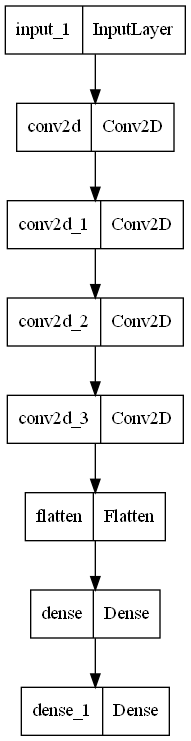

In [44]:
from tensorflow.keras.utils import plot_model
#Create a PNG showing the autoKeras model and its structure 
##print(type(final_model))
#final_model.build(x_test[0].shape)

plot_model(
    final_pruning_model,
    to_file='FinalModel.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)


In [45]:
x_test.shape

(300000, 14, 8, 8)

# Comparing compressed model to original model

In [46]:
def speedTest(numberOfBoards):
    sampleBoardsTFLite = x_test[:numberOfBoards]
    sampleBoards = x_test[:numberOfBoards]
    sampleBoards = numpy.float32(sampleBoards)
    sampleBoardsTFLite = numpy.float32(sampleBoardsTFLite)
    for i in range(numberOfBoards):
        board = sampleBoardsTFLite[i]
        board2 = board.reshape((1,14,8,8))
        sampleBoardsTFLite[i] = board2
   
    print("ORIGINAL MODEL \n")
    origModelFile = 'model.h5'
    start_time = time.time()
    for board in sampleBoards:
        #print(type(board))
        board = numpy.expand_dims(board, axis=0)
        #print(board.shape)
        interpreter.set_tensor(input_index, board2)
        interpreter.invoke()
        prediction = interpreter.get_tensor(output_index)
    timeTaken = (time.time() - start_time)
    print("It took the final model %.3f seonds to evalueate %i boards with an average time of %.3f per board \n" %(timeTaken, numberOfBoards, float(timeTaken/numberOfBoards)) )

    print("FINAL MODEL \n")
    origModelFile = 'model.h5'
    start_time = time.time()
    model = tf.keras.models.load_model(origModelFile)
    for board in sampleBoards:
        #print(type(board))
        board = numpy.expand_dims(board, axis=0)
        #print(board.shape)
        model(board)[0][0]
    timeTaken = (time.time() - start_time)
    print("It took the orginal model %.3f seonds to evalueate %i boards with an average time of %.3f per board \n" %(timeTaken, numberOfBoards, float(timeTaken/numberOfBoards)) )
    
    

In [47]:
speedTest(5000)

ORIGINAL MODEL 

It took the final model 71.544 seonds to evalueate 5000 boards with an average time of 0.014 per board 

FINAL MODEL 

It took the orginal model 15.296 seonds to evalueate 5000 boards with an average time of 0.003 per board 



In [51]:
from scipy import stats

def playingTest(gamesToPlay, depth):
    origModelFile = 'model.h5'
    model = tf.keras.models.load_model(origModelFile)
    movesEachGame = numpy.empty([gamesToPlay])
    engineWins = 0
    stockfishWins = 0
    for i in range(gamesToPlay):
        print('Starting game number: %i' %i)
        movesThisGame, winner = playStockfish(model, depth, False, False)
        movesEachGame[i] = movesThisGame
        if winner:
            engineWins += 1
        else:
            stockfishWins += 1
    mode = stats.mode(movesEachGame, axis = None)
    average = numpy.average(movesEachGame)  
    std = numpy.std(movesEachGame)
    print("\nORIGINAL MODEL \n")
    print('After %i games the average number of moves made per game was %.3f, the standard diviation was %.3f, the mode was %i with a count of %i, the min moves was %i, and the max moves was %i.\n' 
          %(gamesToPlay, average, std, mode[0], mode[1], numpy.min(movesEachGame), numpy.max(movesEachGame)))
    
    print('This engine won %i times and stockfish 13 won %i times \n' 
          % (engineWins, stockfishWins))
    
    movesEachGame = numpy.empty([gamesToPlay])
    engineWins = 0
    stockfishWins = 0
    
    for i in range(gamesToPlay):
        print('Starting game number: %i' %i)
        movesThisGame, winner = playStockfish(None, depth, True, False)
        movesEachGame[i] = movesThisGame
        if winner:
            engineWins += 1
        else:
            stockfishWins += 1
    mode = stats.mode(movesEachGame, axis = None)
    average = numpy.average(movesEachGame)  
    std = numpy.std(movesEachGame)
    print("\nFINAL MODEL \n")
    print('After %i games the average number of moves made per game was %.3f, the standard diviation was %.3f, the mode was %i with a count of %i, the min moves was %i, and the max moves was %i.\n'
          %(gamesToPlay, average, std, mode[0], mode[1], numpy.min(movesEachGame), numpy.max(movesEachGame)))
          
    print('This engine won %i times and stockfish 13 won %i times' 
          % (engineWins, stockfishWins))
        
        

In [52]:
###intpereator must be setup before running 
###this takes a long time to run
playingTest(100, 2) #number of games, depth of the search for a good move

Starting game number: 0
Starting game number: 1
Starting game number: 2
Starting game number: 3
Starting game number: 4
Starting game number: 5
Starting game number: 6
Starting game number: 7
Starting game number: 8
Starting game number: 9
Starting game number: 10
Starting game number: 11
Starting game number: 12
Starting game number: 13
Starting game number: 14
Starting game number: 15
Starting game number: 16
Starting game number: 17
Starting game number: 18
Starting game number: 19
Starting game number: 20
Starting game number: 21
Starting game number: 22
Starting game number: 23
Starting game number: 24
Starting game number: 25
Starting game number: 26
Starting game number: 27
Starting game number: 28
Starting game number: 29
Starting game number: 30
Starting game number: 31
Starting game number: 32
Starting game number: 33
Starting game number: 34
Starting game number: 35
Starting game number: 36
Starting game number: 37
Starting game number: 38
Starting game number: 39
Starting g

KeyboardInterrupt: 

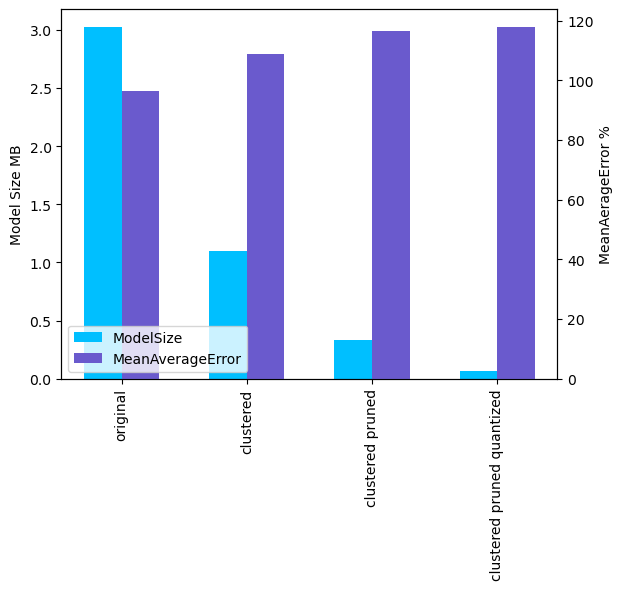

In [54]:
import matplotlib.pyplot as plt
lables = ['original', 'clustered', 'clustered pruned', 'clustered pruned quantized' ]
x = numpy.arange(4)
ax1 = plt.subplot(1,1,1)
w = 0.3
maes = [x * 100 for x in maes]
plt.xticks(x + w /2, lables, rotation='vertical')
pop =ax1.bar(x, (model_sizes), width=w, color='deepskyblue', align='center')
ax1.set_ylabel("Model Size MB")
ax2 = ax1.twinx()
gdp =ax2.bar(x + w, maes, width=w,color='slateblue',align='center')
plt.ylabel('MeanAerageError %')
plt.legend([pop, gdp],['ModelSize', 'MeanAverageError'], loc='lower left')
plt.show()